In [1]:
DETECTION_PATH = r'\\Desktop-0331tte\d\chiletv-testdata\detection'
DETECTION_CSV = r'..\data\testdata_detections.csv'
DETECTION_COLUMNS = [
    'video_id',
    'frame_rate',
    'batch_size',
    'min_face_size',
    'max_frame_size',
    'width',
    'height',
    'video_length',
    'detection_length']
# time content_delta bounding_box key_points

In [2]:
%matplotlib inline

import json
from pathlib import Path
from datetime import timedelta
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_row(file: Path, columns: List[str]):
    with file.open('r', encoding='utf8') as fp:
        obj = json.load(fp)
        obj['video_id'] = file.name[:file.name.index('.')]
        return [obj[c] for c in DETECTION_COLUMNS]
    
def get_dataframe(root: Path, columns: List[str]):
    return pd.DataFrame((get_row(f, columns) for f in root.glob('**/*.detections.json')), columns=columns)

csv_file = Path(DETECTION_CSV)
if csv_file.exists():
    detection_df = pd.read_csv(csv_file)
else:
    detection_df = get_dataframe(Path(DETECTION_PATH), DETECTION_COLUMNS)
    detection_df.to_csv(csv_file, index=False)
detection_df.head()

,video_id,frame_rate,batch_size,min_face_size,max_frame_size,width,height,video_length,detection_length
0,-75gXEApdNQ,15.0,34,20,None,1920,1080,482.400000,2321.592348
1,0VrxAn-goEw,15.0,192,20,None,854,480,536.566667,1241.069981
2,0yTEcgQNoQo,15.0,512,20,None,470,360,1332.000000,1004.816044
3,26wTw6UGoAY,15.0,110,20,None,1280,720,1211.800000,2751.089432
4,3h_idnfM5Mw,15.0,34,20,None,1920,1080,737.400000,2782.304517


In [4]:
detection_df['area'] = detection_df['width'] * detection_df['height']
detection_df['speedup'] = detection_df['video_length'] / detection_df['detection_length']

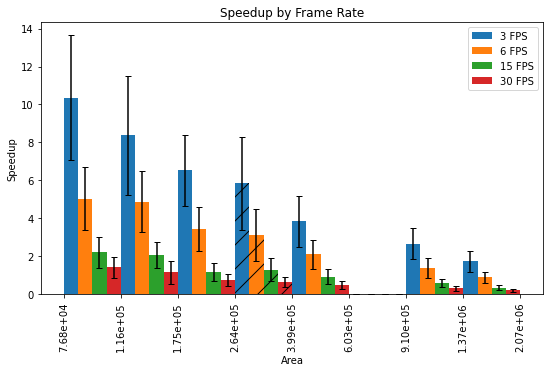

In [5]:
hist_bin_num = 9
search_val = 550

number_of_fps = len(pd.unique(detection_df['frame_rate']))
bin_widths = 1.0 / float(number_of_fps)

min_area = detection_df['area'].min()
max_area = detection_df['area'].max()
hist_bins = np.logspace(np.log10(min_area), np.log10(max_area), hist_bin_num)

interval_idx = pd.IntervalIndex.from_arrays(hist_bins[:-1], hist_bins[1:])
bin_map = {interval:idx for idx, interval in enumerate(interval_idx)}

speedup_df = detection_df.where(detection_df['max_frame_size'].isna())[['area', 'frame_rate', 'speedup']]
speedup_df['interval'] = pd.cut(speedup_df['area'], bins=interval_idx)

speedup_df = speedup_df[['frame_rate', 'interval', 'speedup']]
speedup_df = speedup_df.groupby(['frame_rate', 'interval']).agg([np.mean, np.std]).reset_index()
speedup_df[('speedup', 'mean')].fillna(0, inplace=True)
speedup_df[('speedup', 'std')].fillna(0, inplace=True)

speedup_df['interval'] = [bin_map[interval] for interval in speedup_df['interval']]

# Which bin does search_valxsearch_val lie in?
for i in range(len(hist_bins) - 1):
    if hist_bins[i] < search_val**2 <= hist_bins[i+1]:
        search_idx = i
        break

fig = plt.figure(figsize=(9, 5))
ax = plt.axes()

labels = [f"{i:1.2e}" for i in hist_bins]
label_ctr = number_of_fps * bin_widths * np.arange(len(hist_bins))

for fps_idx, (key, group) in enumerate(speedup_df.groupby('frame_rate')):
    left = np.float32([label_ctr[i] for i in group['interval']])
    right = np.float32([label_ctr[i+1] for i in group['interval']])
    
    xval = left + bin_widths * fps_idx * (right - left)
    yval = group[('speedup', 'mean')].values
    yerr = group[('speedup', 'std')].values
    
    hatch = [None] * len(xval)
    hatch[search_idx] = '/'
    
    ax.bar(xval, yval, bin_widths, align='edge', label=f'{int(key):d} FPS', hatch=hatch)
    ax.errorbar(xval + 0.5 * bin_widths, yval, yerr=yerr, capsize=3, color='black', fmt=' ')

plt.xticks(label_ctr, labels, rotation=90)

plt.title('Speedup by Frame Rate')
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.savefig('images/speedup_by_frame_rate.svg', bbox_inches='tight')
plt.savefig('images/speedup_by_frame_rate.png', bbox_inches='tight')
plt.show()

**Figure \[speedup_by_frame_rate]:** A decrease in the frame rate does improve the time spent detecting faces. The bin which would contain the videos with a resolution of 550x550 is highlithed.